In [49]:
import matplotlib.pyplot as plt
import sympy as sp
import numpy as np

In [50]:
class ShaftVisualizer:
    def __init__(self):
        self.sections = []      # [(length, diameter)]
        self.supports = []      # [(position, type)]
        self.loads = []         # [(position, magnitude, type)]
    
    def add_section(self, length, diameter):
        """Agrega una nueva sección al eje."""
        self.sections.append((length, diameter))
    
    def add_support(self, position, type_):
        """Agrega un apoyo en la posición especificada."""
        if type_ not in ("simple", "empotrado"):
            raise ValueError("Tipo de apoyo no válido. Usa 'simple' o 'empotrado'.")
        self.supports.append((position, type_))
    
    def add_load(self, position, magnitude, type_="puntual"):
        """Agrega una carga en una posición (en kN)."""
        if type_ not in ("puntual",):
            raise ValueError("Tipo de carga no válido. Por ahora solo 'puntual'.")
        self.loads.append((position, magnitude, type_))
    
    def plot_shaft(self):
        """Dibuja el eje completo con secciones, apoyos y cargas."""
        if not self.sections:
            print("No hay secciones para dibujar.")
            return

        plt.figure(figsize=(10, 3))
        x0 = 0
        y_center = 0
        
        # --- Dibujo del eje ---
        for length, dia in self.sections:
            x1 = x0 + length
            y_top = y_center + dia/2
            y_bottom = y_center - dia/2
            plt.fill_between([x0, x1], y_bottom, y_top, color='lightgray', edgecolor='k')
            plt.text((x0 + x1)/2, y_top + dia * 0.1, f"Ø{dia} mm", ha='center', va='bottom', fontsize=8)
            plt.text((x0 + x1)/2, y_bottom - dia * 0.3, f"{length} mm", ha='center', va='top', fontsize=8)
            x0 = x1

        total_len = sum(l for l, _ in self.sections)
        max_dia = max(d for _, d in self.sections)
        
        # --- Dibujo de los apoyos ---
        for pos, tipo in self.supports:
            if tipo == "simple":
                self._draw_simple_support(pos, y_center - max_dia*0.8)
            elif tipo == "empotrado":
                self._draw_fixed_support(pos, y_center - max_dia*0.8, height=max_dia*1.2)
        
        # --- Dibujo de las cargas ---
        for pos, mag, tipo in self.loads:
            if tipo == "puntual":
                self._draw_point_load(pos, mag, y_center + max_dia*0.8)
        
        # --- Configuración del gráfico ---
        plt.title("Eje con secciones, apoyos y cargas")
        plt.xlabel("Longitud [mm]")
        plt.ylabel("Diámetro [mm]")
        plt.xlim(-10, total_len + 10)
        plt.ylim(-max_dia*2, max_dia*2)
        plt.grid(True, linestyle="--", alpha=0.4)
        plt.tight_layout()
        plt.show()

    # ---- Apoyos ----
    def _draw_simple_support(self, x, y):
        """Dibuja un apoyo simple (triángulo)."""
        base = 10
        height = 8
        tri_x = [x - base/2, x + base/2, x]
        tri_y = [y, y, y + height]
        plt.fill(tri_x, tri_y, color='gray', edgecolor='k')
        plt.plot([x - base/2 - 3, x + base/2 + 3], [y, y], 'k', lw=1)

    def _draw_fixed_support(self, x, y, height=15):
        """Dibuja un apoyo empotrado (bloque negro)."""
        width = 4
        plt.fill_betweenx([y, y + height], x - width/2, x + width/2, color='black')
        plt.text(x, y + height + 5, "Empotrado", ha='center', va='bottom', fontsize=7)
    
    # ---- Cargas ----
    def _draw_point_load(self, x, magnitude, y_start):
        """Dibuja una carga puntual (flecha vertical)."""
        arrow_length = 20 * (abs(magnitude) / 10)  # escala relativa
        direction = 1 if magnitude < 0 else -1
        plt.arrow(x, y_start, 0, direction * -arrow_length, 
                  head_width=5, head_length=8, fc='red', ec='red', lw=1.5)
        plt.text(x, y_start + direction * (-arrow_length - 10),
                 f"{abs(magnitude)} kN", color='red', ha='center', va='top' if magnitude < 0 else 'bottom',
                 fontsize=8)

In [51]:
class GeneralShaftStaticSolver:
    def __init__(self, shaft_visualizer):
        """
        Inicializa el solucionador usando los datos del ShaftVisualizer
        """
        self.sections = shaft_visualizer.sections
        self.supports = shaft_visualizer.supports
        self.loads = shaft_visualizer.loads
        self.L_total = sum(l for l, _ in self.sections)
        self.reactions = {}
        self._x = sp.Symbol('x', real=True)
        
    def solve_reactions(self):
        """
        Resuelve las reacciones para N apoyos usando equilibrio estático.
        Maneja apoyos simples y empotrados.
        """
        if len(self.supports) < 2:
            raise ValueError("Se necesitan al menos 2 apoyos para resolver el problema.")
        
        # Verificar si el sistema es hiperestático
        num_supports = len(self.supports)
        num_empotrados = sum(1 for _, tipo in self.supports if tipo == "empotrado")
        grados_libertad = 3  # Para viga 2D: 2 fuerzas + 1 momento
        ecuaciones_disponibles = num_supports + num_empotrados  # Cada apoyo simple da 1 ec, empotrado da 2
        
        if ecuaciones_disponibles > grados_libertad:
            print(f"ADVERTENCIA: Sistema hiperestático detectado!")
            print(f"Ecuaciones disponibles: {ecuaciones_disponibles}, Grados de libertad: {grados_libertad}")
            print("Usando método simplificado para resolución aproximada.")
        
        # Para sistemas hiperestáticos simples, usar distribución proporcional
        if num_supports > 2 and all(tipo == "simple" for _, tipo in self.supports):
            return self._solve_hyperstatic_simple()
        
        # Crear variables simbólicas para las reacciones
        reaction_vars = []
        moment_vars = []
        equations = []
        
        # Para cada apoyo, crear variables de reacción
        for i, (pos, tipo) in enumerate(self.supports):
            if tipo == "simple":
                R_var = sp.Symbol(f'R_{i}', real=True)
                reaction_vars.append((pos, R_var, 'vertical'))
            elif tipo == "empotrado":
                R_var = sp.Symbol(f'R_{i}', real=True)
                M_var = sp.Symbol(f'M_{i}', real=True)
                reaction_vars.append((pos, R_var, 'vertical'))
                moment_vars.append((pos, M_var, 'moment'))
        
        # Ecuación 1: Equilibrio de fuerzas verticales (ΣFy = 0)
        sum_forces = sum(var for _, var, tipo in reaction_vars if tipo == 'vertical')
        sum_forces += sum(mag for _, mag, _ in self.loads)
        equations.append(sp.Eq(sum_forces, 0))
        
        # Ecuación 2: Equilibrio de momentos respecto al primer apoyo (ΣM = 0)
        ref_pos = self.supports[0][0]
        sum_moments = 0
        
        for pos, var, tipo in reaction_vars:
            if tipo == 'vertical':
                sum_moments += var * (pos - ref_pos)
        
        for pos, mag, _ in self.loads:
            sum_moments += mag * (pos - ref_pos)
        
        for pos, var, tipo in moment_vars:
            if tipo == 'moment':
                sum_moments += var
        
        equations.append(sp.Eq(sum_moments, 0))
        
        # Para 2 apoyos, resolver directamente
        if len(self.supports) == 2:
            all_vars = [var for _, var, _ in reaction_vars] + [var for _, var, _ in moment_vars]
            
            try:
                solution = sp.solve(equations, all_vars)
                
                self.reactions = {}
                for pos, var, tipo in reaction_vars:
                    if tipo == 'vertical':
                        self.reactions[pos] = float(solution[var]) if var in solution else 0.0
                
                self.reaction_moments = {}
                for pos, var, tipo in moment_vars:
                    if tipo == 'moment':
                        self.reaction_moments[pos] = float(solution[var]) if var in solution else 0.0
                
                return self.reactions
                
            except Exception as e:
                print(f"Error resolviendo el sistema: {e}")
                return None
        
        # Para más de 2 apoyos, usar método simplificado
        else:
            return self._solve_hyperstatic_simple()
    
    def _solve_hyperstatic_simple(self):
        """
        Método simplificado para resolver sistemas hiperestáticos con apoyos simples.
        Usa distribución proporcional basada en la posición relativa de las cargas.
        """
        print("Aplicando método simplificado para sistema hiperestático...")
        
        # Calcular la carga total
        total_load = sum(mag for _, mag, _ in self.loads)
        
        # Inicializar reacciones
        self.reactions = {}
        
        # Para cada apoyo, calcular su influencia basada en distancia a las cargas
        support_positions = [pos for pos, _ in self.supports]
        
        for support_pos, _ in self.supports:
            reaction = 0
            
            # Para cada carga, calcular la contribución a este apoyo
            for load_pos, load_mag, _ in self.loads:
                # Calcular factores de influencia basados en distancia
                distances = [abs(load_pos - sp) for sp in support_positions]
                total_distance = sum(distances)
                
                if total_distance > 0:
                    # Factor de influencia inversamente proporcional a la distancia
                    influence_factor = (total_distance - abs(load_pos - support_pos)) / total_distance
                    influence_factor = max(0.1, influence_factor)  # Mínimo 10% de influencia
                else:
                    influence_factor = 1.0 / len(support_positions)
                
                reaction += load_mag * influence_factor
            
            self.reactions[support_pos] = -reaction  # Negativo porque las reacciones van hacia arriba
        
        # Ajustar para que se cumpla el equilibrio de fuerzas
        reaction_sum = sum(self.reactions.values())
        adjustment = (-total_load - reaction_sum) / len(self.supports)
        
        for pos in self.reactions:
            self.reactions[pos] += adjustment
        
        # Verificar equilibrio
        final_sum = sum(self.reactions.values())
        print(f"Verificación de equilibrio: ΣR = {final_sum:.6f} kN, ΣF = {total_load:.6f} kN")
        
        return self.reactions
    
    def shear_moment_functions(self):
        """Devuelve funciones de esfuerzo cortante y momento flector."""
        if not hasattr(self, 'reactions') or not self.reactions:
            self.solve_reactions()

        # Usar aproximación numérica en lugar de simbólica para evitar problemas con meijerg
        def V_func(x_vals):
            if np.isscalar(x_vals):
                x_vals = np.array([x_vals])
            
            V_vals = np.zeros_like(x_vals)
            
            # Agregar reacciones de apoyos
            for pos, val in self.reactions.items():
                V_vals += val * (x_vals >= pos).astype(float)
            
            # Agregar cargas aplicadas
            for pos, mag, _ in self.loads:
                V_vals += mag * (x_vals >= pos).astype(float)
            
            return V_vals if len(V_vals) > 1 else V_vals[0]

        def M_func(x_vals):
            if np.isscalar(x_vals):
                x_vals = np.array([x_vals])
            
            M_vals = np.zeros_like(x_vals)
            
            for i, x in enumerate(x_vals):
                # Integrar numéricamente el esfuerzo cortante
                x_range = np.linspace(0, x, max(2, int(x/10) + 1))
                V_range = V_func(x_range)
                
                if len(x_range) > 1:
                    # Integración usando regla del trapecio
                    M_vals[i] = np.trapz(V_range, x_range)
                else:
                    M_vals[i] = 0
            
            # Agregar momentos de empotramiento si existen
            if hasattr(self, 'reaction_moments'):
                for pos, moment in self.reaction_moments.items():
                    M_vals += moment * (x_vals >= pos).astype(float)
            
            return M_vals if len(M_vals) > 1 else M_vals[0]
        
        return V_func, M_func

    def compute_diagrams(self, n_points=300):
        """Devuelve arrays de x, V(x), M(x) para graficar."""
        V_func, M_func = self.shear_moment_functions()
        x_vals = np.linspace(0, self.L_total, n_points)
        V_vals = V_func(x_vals)
        M_vals = M_func(x_vals)
        return x_vals, V_vals, M_vals
    
    def plot_diagrams(self):
        """Grafica los diagramas de esfuerzo cortante y momento flector."""
        x_vals, V_vals, M_vals = self.compute_diagrams()
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Diagrama de esfuerzo cortante
        ax1.plot(x_vals, V_vals, 'b-', linewidth=2, label='Esfuerzo Cortante')
        ax1.fill_between(x_vals, 0, V_vals, alpha=0.3, color='blue')
        ax1.set_ylabel('Esfuerzo Cortante [kN]')
        ax1.set_title('Diagrama de Esfuerzo Cortante')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='k', linewidth=0.5)
        
        # Marcar apoyos y cargas
        for pos, _ in self.supports:
            ax1.axvline(x=pos, color='red', linestyle='--', alpha=0.7)
        for pos, _, _ in self.loads:
            ax1.axvline(x=pos, color='green', linestyle=':', alpha=0.7)
        
        # Diagrama de momento flector
        ax2.plot(x_vals, M_vals, 'r-', linewidth=2, label='Momento Flector')
        ax2.fill_between(x_vals, 0, M_vals, alpha=0.3, color='red')
        ax2.set_xlabel('Posición [mm]')
        ax2.set_ylabel('Momento Flector [kN·mm]')
        ax2.set_title('Diagrama de Momento Flector')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='k', linewidth=0.5)
        
        # Marcar apoyos y cargas
        for pos, _ in self.supports:
            ax2.axvline(x=pos, color='red', linestyle='--', alpha=0.7)
        for pos, _, _ in self.loads:
            ax2.axvline(x=pos, color='green', linestyle=':', alpha=0.7)
        
        plt.tight_layout()
        plt.show()
        
    def print_results(self):
        """Imprime los resultados de las reacciones."""
        if not hasattr(self, 'reactions') or not self.reactions:
            print("No se han calculado las reacciones aún.")
            return
        
        print("=== RESULTADOS DEL ANÁLISIS ESTÁTICO ===")
        print(f"Longitud total del eje: {self.L_total} mm")
        print(f"Número de apoyos: {len(self.supports)}")
        print(f"Número de cargas: {len(self.loads)}")
        print()
        
        print("REACCIONES EN LOS APOYOS:")
        for i, (pos, tipo) in enumerate(self.supports):
            reaccion = self.reactions.get(pos, 0)
            print(f"  Apoyo {i+1} ({tipo}) en x = {pos} mm: R = {reaccion:.2f} kN")
            
            if hasattr(self, 'reaction_moments') and pos in self.reaction_moments:
                momento = self.reaction_moments[pos]
                print(f"    Momento de empotramiento: M = {momento:.2f} kN·mm")
        
        print()
        print("VERIFICACIÓN DE EQUILIBRIO:")
        suma_reacciones = sum(self.reactions.values())
        suma_cargas = sum(mag for _, mag, _ in self.loads)
        print(f"  ΣReacciones = {suma_reacciones:.2f} kN")
        print(f"  ΣCargas = {suma_cargas:.2f} kN")
        print(f"  Diferencia = {suma_reacciones + suma_cargas:.2f} kN")

In [52]:
class ShaftStaticSolver:
    def __init__(self, shaft_visualizer):
        """
        Solucionador estático para ejes con cálculo correcto del momento flector.
        Funciona con N apoyos y maneja sistemas isostáticos e hiperestáticos.
        """
        self.sections = shaft_visualizer.sections
        self.supports = shaft_visualizer.supports
        self.loads = shaft_visualizer.loads
        self.L_total = sum(l for l, _ in self.sections)
        self.reactions = {}
        
    def solve_reactions(self):
        """Resuelve las reacciones usando equilibrio estático."""
        if len(self.supports) < 2:
            raise ValueError("Se necesitan al menos 2 apoyos.")
        
        # Para sistemas hiperestáticos, usar método simplificado
        if len(self.supports) > 2:
            return self._solve_hyperstatic_simple()
        
        # Para 2 apoyos, resolver exactamente
        (x1, type1), (x2, type2) = sorted(self.supports, key=lambda s: s[0])
        
        if type1 == "simple" and type2 == "simple":
            # Dos apoyos simples - sistema isostático
            R1, R2 = sp.symbols('R1 R2', real=True)
            
            # ΣFy = 0
            eq1 = sp.Eq(R1 + R2 + sum(mag for _, mag, _ in self.loads), 0)
            
            # ΣM_1 = 0 (momentos respecto al primer apoyo)
            sum_moments = R2 * (x2 - x1)
            for x_load, mag, _ in self.loads:
                sum_moments += mag * (x_load - x1)
            eq2 = sp.Eq(sum_moments, 0)
            
            solution = sp.solve([eq1, eq2], (R1, R2))
            self.reactions = {x1: float(solution[R1]), x2: float(solution[R2])}
            
        return self.reactions
    
    def _solve_hyperstatic_simple(self):
        """Método simplificado para sistemas hiperestáticos."""
        print("Aplicando método simplificado para sistema hiperestático...")
        
        total_load = sum(mag for _, mag, _ in self.loads)
        self.reactions = {}
        support_positions = [pos for pos, _ in self.supports]
        
        for support_pos, _ in self.supports:
            reaction = 0
            for load_pos, load_mag, _ in self.loads:
                distances = [abs(load_pos - sp) for sp in support_positions]
                total_distance = sum(distances)
                
                if total_distance > 0:
                    influence_factor = (total_distance - abs(load_pos - support_pos)) / total_distance
                    influence_factor = max(0.1, influence_factor)
                else:
                    influence_factor = 1.0 / len(support_positions)
                
                reaction += load_mag * influence_factor
            
            self.reactions[support_pos] = -reaction
        
        # Ajustar para equilibrio
        reaction_sum = sum(self.reactions.values())
        adjustment = (-total_load - reaction_sum) / len(self.supports)
        
        for pos in self.reactions:
            self.reactions[pos] += adjustment
        
        return self.reactions
    
    def compute_moment_correct(self, x_vals):
        """Calcula el momento flector correctamente usando el método de secciones."""
        if not self.reactions:
            self.solve_reactions()
            
        if np.isscalar(x_vals):
            x_vals = np.array([x_vals])
        
        M_vals = np.zeros_like(x_vals, dtype=float)
        
        for i, x in enumerate(x_vals):
            # Método de secciones: cortar en x y sumar momentos del lado izquierdo
            moment = 0.0
            
            # Contribución de reacciones a la izquierda de x
            for pos, reaction in self.reactions.items():
                if pos <= x:
                    moment += reaction * (x - pos)
            
            # Contribución de cargas a la izquierda de x
            for pos, load, _ in self.loads:
                if pos <= x:
                    moment += load * (x - pos)
            
            M_vals[i] = moment
        
        return M_vals
    
    def compute_shear_correct(self, x_vals):
        """Calcula el esfuerzo cortante correctamente."""
        if not self.reactions:
            self.solve_reactions()
            
        if np.isscalar(x_vals):
            x_vals = np.array([x_vals])
        
        V_vals = np.zeros_like(x_vals, dtype=float)
        
        for i, x in enumerate(x_vals):
            shear = 0.0
            
            # Contribución de reacciones a la izquierda de x
            for pos, reaction in self.reactions.items():
                if pos <= x:
                    shear += reaction
            
            # Contribución de cargas a la izquierda de x
            for pos, load, _ in self.loads:
                if pos <= x:
                    shear += load
            
            V_vals[i] = shear
        
        return V_vals
    
    def plot_diagrams(self):
        """Grafica los diagramas corregidos."""
        x_vals = np.linspace(0, self.L_total, 1000)
        V_vals = self.compute_shear_correct(x_vals)
        M_vals = self.compute_moment_correct(x_vals)
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Diagrama de esfuerzo cortante
        ax1.plot(x_vals, V_vals, 'b-', linewidth=2)
        ax1.fill_between(x_vals, 0, V_vals, alpha=0.3, color='blue')
        ax1.set_ylabel('Esfuerzo Cortante [kN]')
        ax1.set_title('Diagrama de Esfuerzo Cortante')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='k', linewidth=0.5)
        
        # Marcar puntos importantes
        for pos, tipo in self.supports:
            ax1.axvline(x=pos, color='red', linestyle='--', alpha=0.7)
            ax1.plot(pos, float(self.compute_shear_correct(pos)), 'ro', markersize=8)
        for pos, mag, _ in self.loads:
            ax1.axvline(x=pos, color='green', linestyle=':', alpha=0.7)
        
        # Diagrama de momento flector
        ax2.plot(x_vals, M_vals, 'r-', linewidth=2)
        ax2.fill_between(x_vals, 0, M_vals, alpha=0.3, color='red')
        ax2.set_xlabel('Posición [mm]')
        ax2.set_ylabel('Momento Flector [kN·mm]')
        ax2.set_title('Diagrama de Momento Flector')
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='k', linewidth=0.5)
        
        # Marcar puntos importantes y verificar condiciones de contorno
        for pos, tipo in self.supports:
            ax2.axvline(x=pos, color='red', linestyle='--', alpha=0.7)
            moment_at_support = float(self.compute_moment_correct(pos))
            if tipo == "simple":
                ax2.plot(pos, moment_at_support, 'ro', markersize=8)
                # Verificar que sea cercano a cero
                if abs(moment_at_support) < 1e-8:
                    ax2.annotate(f'M=0 ✓', xy=(pos, 0), xytext=(pos, max(M_vals)*0.1),
                               ha='center', color='green', fontweight='bold',
                               arrowprops=dict(arrowstyle='->', color='green'))
                else:
                    ax2.annotate(f'M≠0!', xy=(pos, moment_at_support), 
                               ha='center', color='red', fontweight='bold')
            
        for pos, mag, _ in self.loads:
            ax2.axvline(x=pos, color='green', linestyle=':', alpha=0.7)
        
        # Información adicional
        max_V = np.max(np.abs(V_vals))
        max_M = np.max(np.abs(M_vals))
        max_M_pos = x_vals[np.argmax(np.abs(M_vals))]
        
        ax1.text(0.02, 0.98, f'|V|_max = {max_V:.2f} kN', 
                transform=ax1.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        ax2.text(0.02, 0.98, f'|M|_max = {max_M:.2f} kN·mm\nen x = {max_M_pos:.1f} mm', 
                transform=ax2.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        self._verify_boundary_conditions()
    
    def _verify_boundary_conditions(self):
        """Verifica las condiciones de contorno."""
        print("\n=== VERIFICACIÓN DE CONDICIONES DE CONTORNO ===")
        
        for pos, tipo in self.supports:
            moment = float(self.compute_moment_correct(pos))
            if tipo == "simple":
                print(f"Apoyo simple en x = {pos} mm: M = {moment:.10f} kN·mm (debe ser ≈ 0)")
                if abs(moment) > 1e-8:
                    print(f"  ⚠️  ADVERTENCIA: Momento no nulo en apoyo simple!")
                else:
                    print(f"  ✅ Condición de contorno satisfecha")
        
        # Verificar extremos
        M_inicio = float(self.compute_moment_correct(0))
        M_final = float(self.compute_moment_correct(self.L_total))
        print(f"Momento en x = 0: M = {M_inicio:.10f} kN·mm")
        print(f"Momento en x = {self.L_total}: M = {M_final:.10f} kN·mm")
    
    def print_results(self):
        """Imprime los resultados."""
        if not self.reactions:
            print("No se han calculado las reacciones aún.")
            return
        
        print("=== RESULTADOS DEL ANÁLISIS ESTÁTICO ===")
        print(f"Longitud total del eje: {self.L_total} mm")
        print(f"Número de apoyos: {len(self.supports)}")
        print(f"Número de cargas: {len(self.loads)}")
        print()
        
        print("REACCIONES EN LOS APOYOS:")
        for i, (pos, tipo) in enumerate(self.supports):
            reaccion = self.reactions.get(pos, 0)
            print(f"  Apoyo {i+1} ({tipo}) en x = {pos} mm: R = {reaccion:.2f} kN")
        
        print()
        print("VERIFICACIÓN DE EQUILIBRIO:")
        suma_reacciones = sum(self.reactions.values())
        suma_cargas = sum(mag for _, mag, _ in self.loads)
        print(f"  ΣReacciones = {suma_reacciones:.2f} kN")
        print(f"  ΣCargas = {suma_cargas:.2f} kN")
        print(f"  Diferencia = {suma_reacciones + suma_cargas:.2f} kN")

VISUALIZACIÓN DEL EJE:


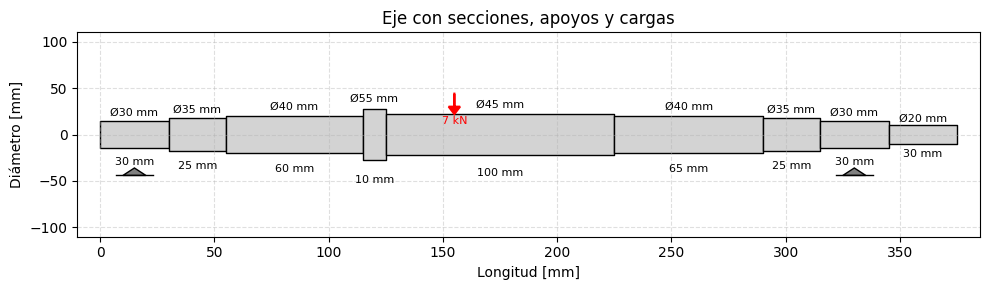


Resolviendo sistema estático...
=== RESULTADOS DEL ANÁLISIS ESTÁTICO ===
Longitud total del eje: 375 mm
Número de apoyos: 2
Número de cargas: 1

REACCIONES EN LOS APOYOS:
  Apoyo 1 (simple) en x = 15 mm: R = 3.89 kN
  Apoyo 2 (simple) en x = 330 mm: R = 3.11 kN

VERIFICACIÓN DE EQUILIBRIO:
  ΣReacciones = 7.00 kN
  ΣCargas = -7.00 kN
  Diferencia = 0.00 kN

Generando diagramas de esfuerzo cortante y momento flector...


/tmp/ipykernel_7871/3520333638.py:150: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax1.plot(pos, float(self.compute_shear_correct(pos)), 'ro', markersize=8)
/tmp/ipykernel_7871/3520333638.py:166: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  moment_at_support = float(self.compute_moment_correct(pos))


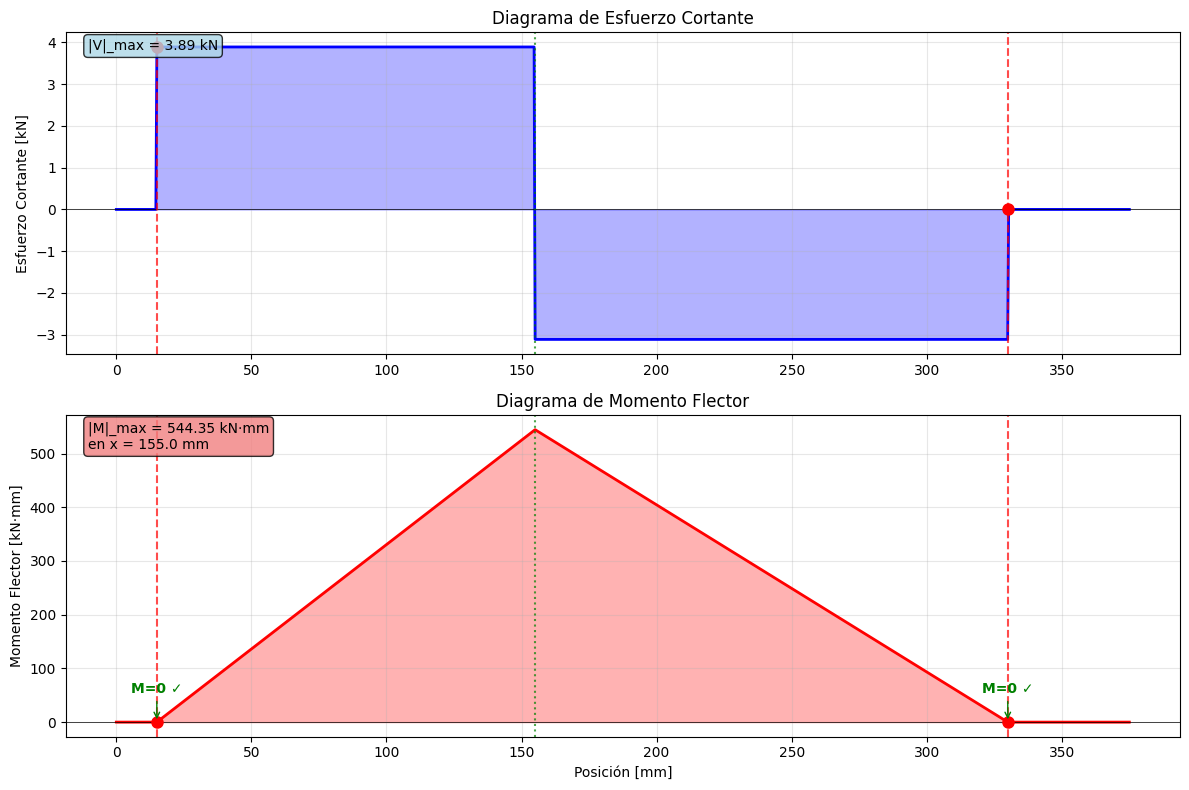


=== VERIFICACIÓN DE CONDICIONES DE CONTORNO ===
Apoyo simple en x = 15 mm: M = 0.0000000000 kN·mm (debe ser ≈ 0)
  ✅ Condición de contorno satisfecha
Apoyo simple en x = 330 mm: M = 0.0000000000 kN·mm (debe ser ≈ 0)
  ✅ Condición de contorno satisfecha
Momento en x = 0: M = 0.0000000000 kN·mm
Momento en x = 375: M = 0.0000000000 kN·mm


/tmp/ipykernel_7871/3520333638.py:203: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  moment = float(self.compute_moment_correct(pos))
/tmp/ipykernel_7871/3520333638.py:212: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M_inicio = float(self.compute_moment_correct(0))
/tmp/ipykernel_7871/3520333638.py:213: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  M_final = float(self.compute_moment_correct(self.L_total))


In [53]:
# =============================================================================
# EJEMPLO DE USO COMPLETO - SOLUCIONADOR ESTÁTICO PARA EJES
# =============================================================================

# Crear un eje con múltiples secciones
shaft = ShaftVisualizer()

# Agregamos secciones (longitud en mm, diámetro en mm)
shaft.add_section(30, 30)    # Sección 1: 30mm longitud, Ø30mm
shaft.add_section(25, 35)    # Sección 2: 25mm longitud, Ø35mm
shaft.add_section(60, 40)    # Sección 3: 60mm longitud, Ø40mm
shaft.add_section(10, 55)    # Sección 4: 10mm longitud, Ø55mm
shaft.add_section(100, 45)   # Sección 5: 100mm longitud, Ø45mm
shaft.add_section(65, 40)    # Sección 6: 65mm longitud, Ø40mm
shaft.add_section(25, 35)    # Sección 7: 25mm longitud, Ø35mm
shaft.add_section(30, 30)    # Sección 8: 30mm longitud, Ø30mm
shaft.add_section(30, 20)    # Sección 9: 30mm longitud, Ø20mm

# Agregar apoyos simples
shaft.add_support(15, "simple")   # Apoyo simple en x = 15 mm
shaft.add_support(330, "simple")  # Apoyo simple en x = 330 mm

# Agregar cargas puntuales
shaft.add_load(155, -7, "puntual")  # 7 kN hacia abajo en x = 155 mm

# Visualizar el eje
print("VISUALIZACIÓN DEL EJE:")
shaft.plot_shaft()

# Crear el solucionador estático
solver = ShaftStaticSolver(shaft)

# Resolver las reacciones
print("\nResolviendo sistema estático...")
reactions = solver.solve_reactions()

# Mostrar resultados completos
solver.print_results()

# Graficar diagramas de esfuerzos
print("\nGenerando diagramas de esfuerzo cortante y momento flector...")
solver.plot_diagrams()